In [3]:
import pynucastro as nuc

In [4]:
lib = nuc.rates.Library("reaclib-2017-10-20")

In [5]:
nuclei = ["p", "he4", "c12", "n13", "n14", "n15", "o14", "o15", "o16", "o17",
          "f17", "f18", "f19", "ne18", "ne19", "ne20", "na20", "na21",
          "mg21", "mg22", "s30", "ni56"]

In [6]:
rp_lib = lib.linking_nuclei(nuclei)

In [7]:
rp_network = nuc.networks.StarKillerNetwork(libraries=rp_lib)

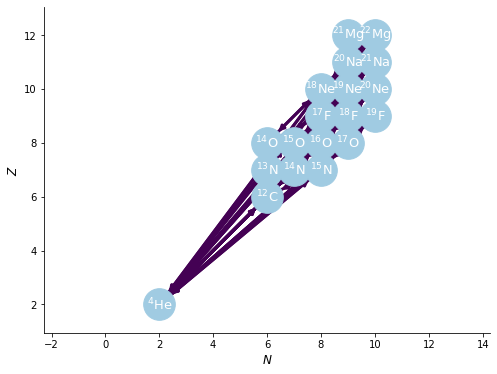

In [9]:
rp_network.plot()